In [52]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj

In [53]:
# gw100m
answer_location = (52.53962045830213, 13.419884901364885, 200)
source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
rssi = np.array([-71.63403554811134, -69.09353142802274, -73.94630524200359, -67.04524365136507, -69.38046352414914, -63.81425676768592, -65.51133843649967, -71.99102431036357, -69.9814290434943, -70.69053819851595])
d = []
for i in range(len(rssi)):
    d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
print(d)

# # gw100m_nobuilding
# answer_location = (52.53962045830213, 13.419884901364885, 200)
# source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
# rssi = np.array([-71.33057463016215, -69.47921756875596, -73.58976692127023, -66.84978429622257, -69.3463866455216, -63.86118311152556, -65.43775615882458, -68.51723739248007, -69.74188545126587, -70.67158737502467])
# d = []
# for i in range(len(rssi)):
#     d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
# print(d)

[394.29288508294167, 295.9958660450461, 511.8755465287958, 234.89856649485617, 305.73897592295174, 163.11736949587115, 197.555748566392, 410.50477950801775, 327.19722509936946, 354.46186954189903]


Receiver location: (52.53871634239289, 13.421109039179084, -161.41763829812407)
[(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]


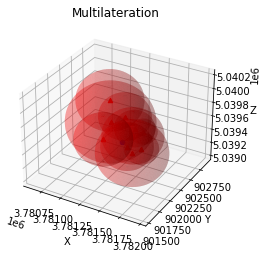

[144.8259443   30.92651019 167.97051985  14.03455779  12.93899007
 119.19284199  95.08326542  30.70489289 201.43941148 166.70430912]


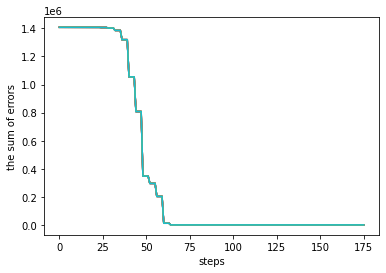

In [64]:
# multilateration program

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

# Convert Cartesian coordinates to GPS coordinates
def to_gps(x, y, z):
    lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
    return lat, lon, alt

# Calculate the distance between the receiver and each source
def distance(xyz_receiver, xyz_source):
    return np.linalg.norm(xyz_source - xyz_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xyz_receiver, xyz_sources, d):
    distances = np.linalg.norm(xyz_sources - xyz_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

# Starting GPS coordinates of the receiver (can be anywhere)
receiver_location = (40.048174, 10.134445, 0)

# Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
xyz_sources = np.array([to_cartesian(*source_location) for source_location in source_locations])
xyz_receiver = np.array(to_cartesian(*receiver_location))

# Perform multilateration to estimate the location of the receiver
result = minimize(error, xyz_receiver, args=(xyz_sources, d))
xyz_receiver_estimated = result.x

# Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
receiver_location_estimated = to_gps(*xyz_receiver_estimated)

print('Receiver location:', receiver_location_estimated)


# Plot the sources and the estimated location of the receiver
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sources
for i in range(len(source_locations)):
    x, y, z = to_cartesian(*source_locations[i])
    ax.scatter(x, y, z, color='r', marker='^')

# Plot the estimated location of the receiver
x, y, z = to_cartesian(*receiver_location_estimated)
ax.scatter(x, y, z, color='b', marker='o')

# Set the labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Multilateration')

print(source_locations)
# Plot circles (or spheres) representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle (or sphere) in meters
    radius = d[i]
    # Get the Cartesian coordinates of the source
    x, y, z = to_cartesian(*source_locations[i])
    # Create a grid of points on the surface of the sphere
    # Sphere in 3D
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    X = x + radius*np.outer(np.cos(u), np.sin(v))
    Y = y + radius*np.outer(np.sin(u), np.sin(v))
    Z = z + radius*np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(X, Y, Z, color='r', alpha=0.2)

plt.show()

# create a figure for error
fig = plt.figure()

plt.plot(errors_array)
plt.xlabel("steps")
plt.ylabel("the sum of errors")
print(errors_array[-1])

# show the plot
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

# Plot the estimated location of the receiver
folium.Marker(location=receiver_location_estimated[:2], icon=folium.Icon(color='purple')).add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



In [57]:
# create every pattern of 4 or more beacons
import itertools

source_locations_iter = []
d_iter = []
for n in range(4,len(source_locations)+1):
	for source_location in itertools.combinations(source_locations, n):
	    source_locations_iter.append(list(source_location))
	    
for n in range(4,len(d)+1):
	for d_i in itertools.combinations(d, n):
	    d_iter.append(list(d_i))
print(source_locations_iter)
print(d_iter)

[[(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.54022829654233, 13.424028618727982, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53768690920158, 13.423827698593255, 19)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53701243697258, 13.41926365424317, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53765506974833, 13.416535624425991, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715

[[94.64158802151064, 207.4188209112292, 4, 39.18850487087966], [92.32657583641398, 314.0141821653474, 4, 35.5359405422891], [87.53894686942465, 365.67750557063977, 4, 43.03961568421173], [91.85353547219988, 300.3878928406041, 4, 39.488211345355715], [85.10915045119127, 306.43102384675893, 4, 43.66216124531609], [126.7835639876427, 438.0463451194177, 4, 63.21764199377315], [111.71265290581944, 196.02922962261644, 4, 28.830258389621083], [28.295375790397138, 267.80232775526827, 4, 15.384169826943959], [57.940108357981245, 159.37771122543612, 4, 21.686025045994192], [56.13596473740771, 160.44643648179414, 4, 22.91867319607923], [7.970242331607928, 198.7666995035059, 4, 5.126603983642761], [29.62026930884972, 202.2954439557687, 4, 18.379297648872026], [53.52674307817819, 312.44614578782983, 4, 31.709322281634105], [51.30861698658462, 247.61691711166364, 4, 31.457521276070217], [56.514944292070915, 209.5983660472611, 4, 24.834132139442445], [13.306609598330681, 217.83635692522083, 4, 8.4377

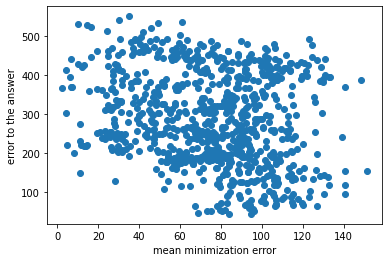

In [66]:
# multilateration with every patterns

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

# Convert Cartesian coordinates to GPS coordinates
def to_gps(x, y, z):
    lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
    return lat, lon, alt

# Calculate the distance between the receiver and each source
def distance(xyz_receiver, xyz_source):
    return np.linalg.norm(xyz_source - xyz_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xyz_receiver, xyz_sources, d):
    distances = np.linalg.norm(xyz_sources - xyz_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

xyz_receiver_estimated_list = []
receiver_locations_estimated = []
error_answer_minimization = []

for i in range(len(d_iter)):

    source_locations = source_locations_iter[i]
    distance = d_iter[i]

    # Starting GPS coordinates of the receiver (can be anywhere)
    receiver_location = (40.048174, 10.134445, 0)

    # Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
    xyz_sources = np.array([to_cartesian(*source_location) for source_location in source_locations])
    xyz_receiver = np.array(to_cartesian(*receiver_location))

    # Perform multilateration to estimate the location of the receiver
    result = minimize(error, xyz_receiver, args=(xyz_sources, distance))
    xyz_receiver_estimated = result.x
    xyz_receiver_estimated_list.append(xyz_receiver_estimated)

    error_answer = np.linalg.norm(to_cartesian(*answer_location)-xyz_receiver_estimated)
    error_answer_minimization.append([np.mean(errors_array[-1]), error_answer, len(distance), np.std(errors_array[-1])])

    # Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
    receiver_location_estimated = to_gps(*xyz_receiver_estimated)
    receiver_locations_estimated.append(receiver_location_estimated)

    # print('Receiver location:', xyz_receiver_estimated)
    # print('Receiver location:', receiver_location_estimated)
    # print('error', np.sum(errors_array[-1]))

print(error_answer_minimization)
error_answer_minimization.sort(key=lambda item: item[0])
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error")
plt.ylabel("error to the answer")
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

for i in range(len(receiver_locations_estimated)):
# Plot the estimated location of the receiver
    folium.Marker(location=receiver_locations_estimated[i][:2], icon=folium.Icon(color='purple'), tooltip=f'Point {i}').add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



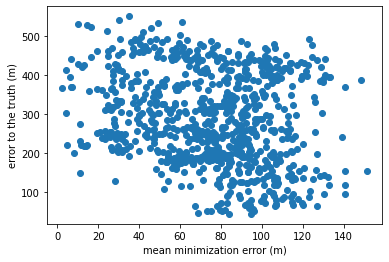

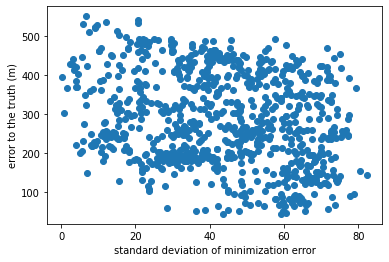

[]
[[365.54188358176737, 301.348780923685, 412.4865681437775, 218.54089078316701, 393.32386420396824, 440.5263071992991, 368.08980884333437, 198.7666995035059, 529.3607272384883, 427.3202599409181, 229.10025982289218, 273.8333824882946, 147.1628280588567, 420.22821867234165, 423.5999253736128, 217.83635692522083, 218.5100247558898, 220.60068493199276, 356.9593254834298, 445.20064881335253, 522.7191180402194, 363.79938156753815, 461.37812400125677, 236.5473026163754, 360.66522211237606, 310.0182037038049, 255.21289371038267, 242.20471788526683, 348.447300345871, 512.9142132729108, 312.64202809859796, 447.1979361056539, 323.3080401171636, 423.18740321106463, 252.66856500391856, 364.48183147891774, 253.00875598406864, 366.4137312131824, 469.62996767051845, 317.39281153028344, 383.13394251038915, 244.01336539801207, 267.80232775526827, 428.47458552686277, 235.48334133440832, 239.39533757393133, 243.21908054722815, 250.69620411446488, 425.68992839076645, 208.1890459155842, 202.2954439557687

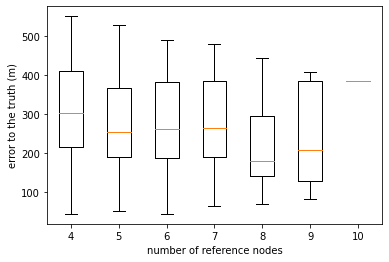

In [71]:
# visualization of multilateration with every pattern
# the relation between error to the truth and mean minimization error, number of reference nodes
error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error (m)")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("standard deviation of minimization error")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

plt.figure(facecolor="white")
error_answer_reference_boxplot = [[] for _ in range(20)]
print(error_answer_reference_boxplot[0])

for i in range(len(error_answer_minimization)):
    error_answer_reference_boxplot[error_answer_minimization[i][2]-4].append(error_answer_minimization[i][1])
print(error_answer_reference_boxplot)
plt.boxplot(error_answer_reference_boxplot[:7])
plt.xticks([i for i in range(1,8)],[i for i in range(4,11)])
plt.xlabel("number of reference nodes")
plt.ylabel("error to the truth (m)")
plt.show()

In [73]:
# multilateration with provided altitude of the drone


array([144.8259443 ,  30.92651019, 167.97051985,  14.03455779,
        12.93899007, 119.19284199,  95.08326542,  30.70489289,
       201.43941148, 166.70430912])